# Long-Short Strategy, Part 2: Trading signals with LightGBM and CatBoost

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. `trading_signals_with_lightgbm_and_catboost`  (this noteboook): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

We'll subset the dataset created in the preceding notebook through the end of 2016 to cross-validate several model configurations for various lookback and lookahead windows, as well as different roll-forward periods and hyperparameters. 

Our approach to model selection will be similar to the one we used in the previous chapter and uses the custom `MultipleTimeSeriesCV` introduced in [Chapter 7, Linear Models – From Risk Factors to Return Forecasts](../07_linear_models).

## Imports & Settings

In [1]:
import warnings
import datetime

from timeseriescv.cross_validation import CombPurgedKFoldCV

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from tqdm import tqdm

from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [4]:
sns.set_style('whitegrid')

In [5]:
YEAR = 365*24
idx = pd.IndexSlice

## Get Data

We select the train and validation sets, and identify labels and features:

In [6]:
data = (pd.read_hdf('data.h5', 'model_data')
            .sort_index())
            #.loc[idx[:, :'2016'], :]) # train & validation period
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 349545 entries, (Timestamp('2019-05-03 18:00:00'), 'atom-usd') to (Timestamp('2021-03-27 06:00:00'), 'xtz-usd')
Data columns (total 32 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   rsi          349251 non-null  float64
 1   bb_high      349146 non-null  float64
 2   bb_low       349146 non-null  float64
 3   NATR         349251 non-null  float64
 4   ATR          349251 non-null  float64
 5   PPO          349020 non-null  float64
 6   MACD         348852 non-null  float64
 7   sector       349545 non-null  int64  
 8   r01          349524 non-null  float64
 9   r05          349440 non-null  float64
 10  r10          349335 non-null  float64
 11  r21          349104 non-null  float64
 12  r42          348663 non-null  float64
 13  r63          348222 non-null  float64
 14  r01dec       349419 non-null  float64
 15  r05dec       349440 non-null  float64
 16  r10dec       349335 non-nu

In [7]:
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist() # features are columns not containing '_fwd'

## Model Selection: Lookback, lookahead and roll-forward periods

In [8]:
tickers = data.index.get_level_values('ticker').unique()

We may want to predict 1, 5 or 21-day returns:

In [9]:
lookaheads = [1, 5, 21]

In [10]:
categoricals = ['year', 'month', 'sector', 'weekday']

We select 4.5 and one years as the length of our training periods; test periods are one and three months long. Since we are using two years (2015/16) for validation, a one-month test period implies 24 folds.

In [11]:
rows = data.unstack('ticker').shape[0]

In [12]:
#train_length=int(0.8*rows)
#test_length=int(0.2*rows)
#train_lengths = [train_length, train_length/8]
#test_lengths = [test_length, test_length/3]
n_splits = [5, 10]

In [13]:
test_params = list(product(lookaheads, n_splits))

In [14]:
results_path = Path('results', 'cryptos')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Baseline: Linear Regression

We always want to know how much our (gradient boosting) is improving over a simpler baseline (if at all..).

In [15]:
lr = LinearRegression()

In [16]:
lookahead=1
label = f'r{lookahead:02}_fwd'
print('label')
data.shape, data.loc[:, features + [label]].dropna().shape

label


((349545, 32), (347912, 30))

In [17]:
data.unstack('ticker').index + datetime.timedelta(hours=8)

DatetimeIndex(['2019-05-04 02:00:00', '2019-05-04 03:00:00',
               '2019-05-04 04:00:00', '2019-05-04 05:00:00',
               '2019-05-04 06:00:00', '2019-05-04 07:00:00',
               '2019-05-04 08:00:00', '2019-05-04 09:00:00',
               '2019-05-04 10:00:00', '2019-05-04 11:00:00',
               ...
               '2021-03-27 05:00:00', '2021-03-27 06:00:00',
               '2021-03-27 07:00:00', '2021-03-27 08:00:00',
               '2021-03-27 09:00:00', '2021-03-27 10:00:00',
               '2021-03-27 11:00:00', '2021-03-27 12:00:00',
               '2021-03-27 13:00:00', '2021-03-27 14:00:00'],
              dtype='datetime64[ns]', name='date', length=16645, freq=None)

In [18]:
pred_times = pd.Series(index=data.unstack('ticker').index,
                       data=data.unstack('ticker').index + datetime.timedelta(hours=lookahead))
pred_times

date
2019-05-03 18:00:00   2019-05-03 19:00:00
2019-05-03 19:00:00   2019-05-03 20:00:00
2019-05-03 20:00:00   2019-05-03 21:00:00
2019-05-03 21:00:00   2019-05-03 22:00:00
2019-05-03 22:00:00   2019-05-03 23:00:00
                              ...        
2021-03-27 02:00:00   2021-03-27 03:00:00
2021-03-27 03:00:00   2021-03-27 04:00:00
2021-03-27 04:00:00   2021-03-27 05:00:00
2021-03-27 05:00:00   2021-03-27 06:00:00
2021-03-27 06:00:00   2021-03-27 07:00:00
Name: date, Length: 16645, dtype: datetime64[ns]

In [19]:
lr_metrics = []

# iterate over our three CV configuration parameters
for lookahead, n_splits in tqdm(test_params):
    label = f'r{lookahead:02}_fwd'
    df = pd.get_dummies(data.loc[:, features + [label]].dropna(), 
                        columns=categoricals, 
                        drop_first=True)
    X, y = df.drop(label, axis=1), df[label]

    #n_splits = int(2 * YEAR / test_length)
    #n_splits = 10
    #cv = MultipleTimeSeriesCV(n_splits=n_splits,
    #                          test_period_length=test_length,
    #                          lookahead=lookahead,
    #                          train_period_length=train_length)
    cv = CombPurgedKFoldCV(n_splits=n_splits)
    # compute lookahead
    pred_times = pd.Series(index=X.index,
                       data=X.index.get_level_values('date') + datetime.timedelta(hours=lookahead))
    eval_times = pd.Series(index=X.index,
                       data=X.index.get_level_values('date') + datetime.timedelta(hours=lookahead))

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X, pred_times=pred_times, eval_times=eval_times)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([lookahead, 
                       n_splits,
                       np.mean(ic),
                       spearmanr(preds.y_true, preds.y_pred)[0]
                      ])

columns = ['lookahead', 'n_splits', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

100%|██████████| 6/6 [00:47<00:00,  7.98s/it]


In [20]:
lr_metrics

,lookahead,n_splits,ic_by_day,ic
0,1,5,0.071809,0.066099
1,1,10,0.079138,0.076523
2,5,5,0.072420,0.064129
3,5,10,0.072696,0.063726
4,21,5,0.041376,0.021779
5,21,10,0.059206,0.042315


### Information Coefficient - Distribution by Lookahead

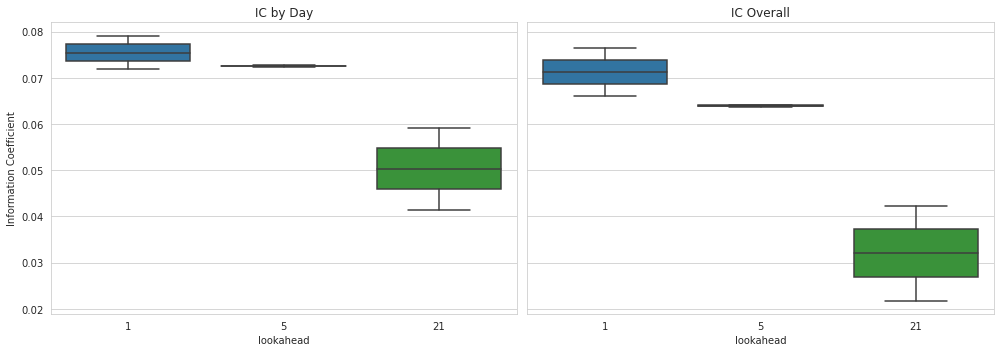

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5), sharey=True)

# plot average of daily IC values
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')

# plot IC across all predictions
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()

### Best Train/Test Period Lengths

For one- and five-day return forecasts, shorter train- and test-length yield better results in terms of daily avg IC:

In [22]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic_by_day')))

,lookahead,n_splits,ic_by_day,ic
1,1,10,0.079138,0.076523
0,1,5,0.071809,0.066099
3,5,10,0.072696,0.063726
2,5,5,0.072420,0.064129
5,21,10,0.059206,0.042315
4,21,5,0.041376,0.021779


In [23]:
lr_metrics.to_csv(results_path / 'lin_reg_metrics.csv', index=False)
lr_metrics

,lookahead,n_splits,ic_by_day,ic
0,1,5,0.071809,0.066099
1,1,10,0.079138,0.076523
2,5,5,0.072420,0.064129
3,5,10,0.072696,0.063726
4,21,5,0.041376,0.021779
5,21,10,0.059206,0.042315


## LightGBM Model Tuning

The notebook example iterates over many configurations, optionally using random samples to speed up model selection using a diverse subset. The goal is to identify the most impactful parameters without trying every possible combination.

In [24]:
def get_fi(model):
    """Return normalized feature importance as pd.Series"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Hyperparameter Options

The `base_params` are not affected by cross-validation:

In [25]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

We choose the following parameters and values to select our best model (see book chapter for detail):

In [26]:
# constraints on structure (depth) of each tree
max_depths = [2, 3, 5, 7]
num_leaves_opts = [2 ** i for i in max_depths]
min_data_in_leaf_opts = [250, 500, 1000]

# weight of each new tree in the ensemble
learning_rate_ops = [.01, .1, .3]

# random feature selection
feature_fraction_opts = [.3, .6, .95]

In [27]:
param_names = ['learning_rate', 'num_leaves',
               'feature_fraction', 'min_data_in_leaf']

In [28]:
cv_params = list(product(learning_rate_ops,
                         num_leaves_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 108


### Train/Test Period Lengths

In [29]:
lookaheads = [1, 5, 21]
label_dict = dict(zip(lookaheads, labels))

We only use test periods of 63 days length to save some model training and evaluation time.

In [30]:
train_lengths = [int(4.5 * 252), 252]
test_lengths = [63]
n_splits = [5, 10]

In [31]:
test_params = list(product(lookaheads, n_splits))
for test_param in test_params:
    print(test_param)
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))
for test_param in test_params:
    print(test_param)

(1, 5)
(1, 10)
(5, 5)
(5, 10)
(21, 5)
(21, 10)
Train configs: 6
(1, 5)
(1, 10)
(21, 10)
(5, 5)
(21, 5)
(5, 10)


### Categorical Variables

We integer-encode categorical variables with values starting at zero, as expected by LightGBM (not necessary
as long as the category codes have values less than $2^{32}$, but avoids a warning)

In [32]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Custom Loss Function: Information Coefficient

In [33]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Run Cross-Validation

To explore the hyperparameter space, we specify values for key parameters that we would like to test in combination.
The sklearn library supports `RandomizedSearchCV` to cross-validate a subset of parameter combinations that are sampled
 randomly from specified distributions. We will implement a custom version that allows us to monitor performance so
  we can abort the search process once we're satisfied with the result, rather than specifying a set number of
   iterations beforehand.

In [34]:
lgb_store = Path(results_path / 'tuning_lgb.h5')

In [35]:
labels = sorted(data.filter(like='fwd').columns)
features = data.columns.difference(labels).tolist()
features

['ATR',
 'MACD',
 'NATR',
 'PPO',
 'bb_high',
 'bb_low',
 'month',
 'r01',
 'r01dec',
 'r01q_sector',
 'r05',
 'r05dec',
 'r05q_sector',
 'r10',
 'r10dec',
 'r10q_sector',
 'r21',
 'r21dec',
 'r21q_sector',
 'r42',
 'r42dec',
 'r42q_sector',
 'r63',
 'r63dec',
 'r63q_sector',
 'rsi',
 'sector',
 'weekday',
 'year']

In [36]:
label_dict = dict(zip(lookaheads, labels))

In [37]:
num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
num_boost_round = num_iterations[-1]

In [38]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

We iterate over our six CV configurations and collect the resulting metrics:

In [39]:
iterations = 0
# used to include train_length and test_length
for lookahead, n_splits in test_params:
    iterations += 1
    print('iterations {}'.format(iterations))
    if iterations > 3:
        print('break outer loop')
        break
    # randomized grid search
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 2),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    # set up cross-validation
    print(f'Lookahead: {lookahead:2.0f} | '
          f'Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | '
          f'Params: {len(cv_params_):3.0f} | '
          f'Train configs: {len(test_params)}')

    # time-series cross-validation
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    
    # binary dataset
    lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                           label=outcome_data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    T = 0
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    inner_iterations = 0
    # iterate over (shuffled) hyperparameter combinations
    for p, param_vals in enumerate(cv_params_):
        inner_iterations += 1
        print('inner_iterations {}'.format(inner_iterations))
        if inner_iterations > 3:
            print('break inner loop')
            break
        key = f'{lookahead}/{n_splits}/' + '/'.join([str(p) for p in param_vals])
        params = dict(zip(param_names, param_vals))
        params.update(base_params)

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)

        cv = CombPurgedKFoldCV(n_splits=n_splits)
        # compute lookahead
        pred_times = pd.Series(index=outcome_data.index,
                           data=outcome_data.index.get_level_values('date') + datetime.timedelta(hours=lookahead))
        eval_times = pd.Series(index=outcome_data.index,
                           data=outcome_data.index.get_level_values('date') + datetime.timedelta(hours=lookahead))


        # iterate over folds
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data, pred_times=pred_times, eval_times=eval_times)):
            
            # select train subset
            lgb_train = lgb_data.subset(used_indices=train_idx.tolist(),
                                       params=params).construct()
            
            # train model for num_boost_round
            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)
            # log feature importance
            if i == 0:
                fi = get_fi(model).to_frame()
            else:
                fi[i] = get_fi(model)

            # capture predictions
            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
            
            # record predictions for each fold
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        
        # combine fold results
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        
        # compute IC per day
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()
        
        # compute IC across all predictions
        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        
        # collect metrics
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        print('metrics: \n{}'.format(metrics))
        msg = f'\t{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["learning_rate"]:5.2f} | '
        msg += f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | {params["min_data_in_leaf"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)

        # persist results for given CV run and hyperparameter combination
        metrics.to_hdf(lgb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(lgb_store, 'daily_ic/' + key)
        fi.T.describe().T.assign(**params).to_hdf(lgb_store, 'fi/' + key)
        cv_preds.to_hdf(lgb_store, 'predictions/' + key)

iterations 1
inner_iterations 1
metrics: 
learning_rate           0.300000
num_leaves              4.000000
feature_fraction        0.950000
min_data_in_leaf     1000.000000
t                     113.154237
daily_ic_mean           0.111893
daily_ic_mean_n        10.000000
daily_ic_median         0.121735
daily_ic_median_n      10.000000
10                      0.085563
25                      0.080149
50                      0.075069
75                      0.073170
100                     0.071495
150                     0.068272
200                     0.066249
250                     0.064647
300                     0.063366
350                     0.062148
400                     0.062186
450                     0.061692
500                     0.061214
dtype: float64
	  0 | 00:01:53 (113) |  0.30 |   4 | 95% | 1000 |   8.56% |  11.19% |   10 |  12.17% |   10
inner_iterations 2
metrics: 
learning_rate          0.010000
num_leaves             4.000000
feature_fraction       0.600000

## CatBoost Model Tuning

We repeat a similar process for CatBoost - see book and CatBoost [docs](https://catboost.ai/docs/concepts/about.html) for detail.

### Hyperparameter Options

In [40]:
param_names = ['max_depth', 'min_child_samples']

max_depth_opts = [3, 5, 7, 9]
min_child_samples_opts = [20, 250, 500]

In [41]:
cv_params = list(product(max_depth_opts,
                         min_child_samples_opts))
n_params = len(cv_params)

### Train/Test Period Lengths

In [42]:
lookaheads = [1, 5, 21]
label_dict = dict(zip(lookaheads, labels))

In [43]:
#train_lengths = [int(4.5 * 252), 252]
#test_lengths = [63]

In [44]:
n_splits = [5, 10]

test_params = list(product(lookaheads,
                           n_splits,))

### Custom Loss Function

In [45]:
class CatBoostIC(object):
    """Custom IC eval metric for CatBoost"""

    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return True

    def evaluate(self, approxes, target, weight):
        target = np.array(target)
        approxes = np.array(approxes).reshape(-1)
        rho = spearmanr(approxes, target)[0]
        return rho, 1

    def get_final_error(self, error, weight):
        # Returns final value of metric based on error and weight
        return error

### Run Cross-Validation

In [46]:
cb_store = Path(results_path / 'tuning_catboost.h5')

In [47]:
num_iterations = [10, 25, 50, 75] + list(range(100, 1001, 100))
num_boost_round = num_iterations[-1]

In [48]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [ ]:
iteration = 0
for lookahead, n_splits in test_params:
    iteration += 1
    print('iteration {}'.format(iteration))
    if iteration > 3:
        print('break loop')
        break
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 1),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    #n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | n_splits: {n_splits:3.0f} | '
          f'Params: {len(cv_params_):3.0f} | Train configs: {len(test_params)}')

    #cv = MultipleTimeSeriesCV(n_splits=n_splits,
    #                          lookahead=lookahead,
    #                          test_period_length=test_length,
    #                          train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()
    cat_cols_idx = [outcome_data.columns.get_loc(c) for c in categoricals]
    catboost_data = Pool(label=outcome_data[label],
                         data=outcome_data.drop(label, axis=1),
                         cat_features=cat_cols_idx)
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    key = f'{lookahead}/{n_splits}'
    T = 0

    inner_iteration = 0
    for p, param_vals in enumerate(cv_params_):
        inner_iteration += 1
        print('iteration {}'.format(inner_iteration))
        if inner_iteration > 3:
            print('break loop')
            break
        params = dict(zip(param_names, param_vals))
        # uncomment if running with GPU
        params['task_type'] = 'GPU'

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)

        cv = CombPurgedKFoldCV(n_splits=n_splits)
        # compute lookahead
        pred_times = pd.Series(index=outcome_data.index,
                           data=outcome_data.index.get_level_values('date') + datetime.timedelta(hours=lookahead))
        eval_times = pd.Series(index=outcome_data.index,
                           data=outcome_data.index.get_level_values('date') + datetime.timedelta(hours=lookahead))


        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data, pred_times=pred_times, eval_times=eval_times)):
            train_set = catboost_data.slice(train_idx.tolist())

            model = CatBoostRegressor(**params)
            model.fit(X=train_set,
                      verbose_eval=False)

            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_names_]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, ntree_end=n)
                      for n in num_iterations}
            cv_preds.append(y_test.to_frame(
                'y_test').assign(**y_pred).assign(i=i))

        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()

        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0]
              for n in num_iterations]
        t = time() - start
        T += t
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n,
                             daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        print('metrics: \n{}'.format(metrics))

        msg = f'{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["max_depth"]:3.0f} | {params["min_child_samples"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)
        metrics.to_hdf(cb_store, 'metrics/' + key)
        ic_by_day.assign(**params).to_hdf(cb_store, 'daily_ic/' + key)
        cv_preds.to_hdf(cb_store, 'predictions/' + key)

iteration 1
Lookahead:  1 | n_splits:   5 | Params:  12 | Train configs: 6
iteration 1


metrics: 
max_depth              3.000000
min_child_samples    500.000000
t                    155.384712
daily_ic_mean          0.006346
daily_ic_mean_n       75.000000
daily_ic_median        0.000000
daily_ic_median_n     10.000000
10                    -0.000618
25                     0.002054
50                     0.003844
75                     0.003893
100                    0.003886
200                    0.003364
300                    0.003143
400                    0.003126
500                    0.003133
600                    0.003132
700                    0.003151
800                    0.003139
900                    0.003138
1000                   0.003147
dtype: float64
  0 | 00:02:35 (155) |   3 |  500 |   0.39% |  0.63% |   75 |  0.00% |   10
iteration 2
metrics: 
max_depth              9.000000
min_child_samples     20.000000
t                    246.072882
daily_ic_mean          0.005613
daily_ic_mean_n      200.000000
daily_ic_median        0.003099
daily_ic_medi

metrics: 
max_depth              7.000000
min_child_samples    250.000000
t                    205.621407
daily_ic_mean          0.008298
daily_ic_mean_n       50.000000
daily_ic_median        0.003567
daily_ic_median_n     50.000000
10                     0.000727
25                     0.003931
50                     0.004406
75                     0.004116
100                    0.005480
200                    0.005807
300                    0.005750
400                    0.005904
500                    0.005898
600                    0.005886
700                    0.006096
800                    0.005826
900                    0.005876
1000                   0.005937
dtype: float64
  2 | 00:10:07 (206) |   7 |  250 |   0.61% |  0.83% |   50 |  0.36% |   50
iteration 4
break loop
iteration 2
Lookahead:  1 | n_splits:  10 | Params:  12 | Train configs: 6
iteration 1


metrics: 
max_depth               9.000000
min_child_samples      20.000000
t                     815.868315
daily_ic_mean           0.006080
daily_ic_mean_n      1000.000000
daily_ic_median         0.002959
daily_ic_median_n    1000.000000
10                      0.002741
25                      0.003509
50                      0.003972
75                      0.003853
100                     0.004414
200                     0.004472
300                     0.004625
400                     0.004622
500                     0.004720
600                     0.004724
700                     0.004739
800                     0.004767
900                     0.004777
1000                    0.004811
dtype: float64
  0 | 00:13:36 (816) |   9 |   20 |   0.48% |  0.61% |  1000 |  0.30% |  1000
iteration 2
